In [1]:
from generate import *
import numpy as np
from UMRtools import *
import time

lum in LMS = [0.45436904 0.47353315 0.0720978 ]
[[1.31265115 0.37916654 0.17658182]
 [0.37916654 0.43588297 0.06613005]
 [0.17658182 0.06613005 1.03101131]]
[[10.82668925 -2.48855249  0.0461736 ]
 [-2.48855249  1.38614356 -0.12768065]
 [ 0.0461736  -0.12768065  1.15767798]]
18.53509145317477
0.012775991216413523
range_deg = 0.034479770809412, buffer_deg = 0.038327973649240565
UMRtools verison: v1.2


In [9]:
#生成grating
def Generate_Gratings(C,P,SF,D,frameRate,size):
    '''
    C:contrast,范围在[0,0.5]
    P:#相位,范围[0,2pi)
    SF:spatial frequency,建议范围在10到40之间
    D:方向,范围[0,pi]
    frameRate:帧率（一秒几帧，=1就是静止的,>1就是动的)
    size:图片大小
    '''
    path="/home/zhaobenyan/model/data_save/gratings/"
    print(path)
    mk_path(path)
    generate_input(path,C,P,SF,D,frameRate,size)
    # static_color-grid_1
   

/home/zhaobenyan/model/data_save/gratings/
32 pixels
crest in sRGB: [ 1.5214511  -1.83242368  0.72781358]
valley in sRGB: [-18.30753009   1.0386155    0.67997673]
0.0045504840286657855 degree per pixel
ecc = 0.034479770809412, buffer_ecc = 0.038327973649240565
1
adjusted to 1 frames in total
sharpness=1.0
sRGB space is not enough to represent the color
(array([-18.30749836,  -1.8322707 ,   0.67997676]), array([1.52144137, 1.03861519, 0.72781314]))


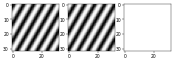

In [16]:
C=np.array([0.45])
P=np.array([0.5*np.pi])
SF = np.arange(36,40,10)#36
D = np.array([np.pi/6])  # 方向范围[0,pi]
frameRate=1
size=32
Generate_Gratings(C,P,SF,D,frameRate,size)

In [19]:
#运行代码并记录时间
def Run_Our_Model(run_time=1):
    '''
    固定使用config文件为minimal.cfg
    run_time:运行时间(s),默认为1s
    log_on:是否打印一些中间值
    '''
    log_on=True
    with open(f"{SRC_DIR}/minimal.cfg", 'r') as file:
    # 读取文件的每一行，并用列表保存
      lines = file.readlines()
      for i in range(len(lines)):
          if "nt =" in lines[i] and "#nt =" not in lines[i] and lines[i][0]=='n':
              lines[i] = f"nt ={int(8000*run_time)} \n"
              if log_on:
                  print(f"changed {int(8000*run_time)}") #LOGfStimulus = static_color-grid_test1.bin
          if "fStimulus =" in lines[i] and "#fStimulus =" not in lines[i]:
              lines[i] = f"fStimulus = static_color-grid_1.bin \n"
              if log_on:
                  print(f"changed static_color-grid_1.bin")   
      with open(f"{SRC_DIR}/minimal.cfg", 'w') as file:
          # 将修改后的行重新写入到文件中
          file.writelines(lines)
    



In [20]:
Run_Our_Model()

changed static_color-grid_1.bin
changed 8000


In [ ]:
os.system(f'cd {PATCHFAST_DIR} && {BIN_DIR}patch_fast -c {SRC_DIR}minimal{3}.cfg > {model_log_path}{now_time_str()}.log')